## Condy Kan
# Assignment 4: Data Management and Regression Analysis
### Concept
An important way to test the relationship between two variables Y and X is to run the model: Y = a + bX using ordinary least squares (OLS). When we run regressions, we not only estimate the parameters a and b that can then be used for predictions, we also get to understand how well the model fits (i.e., how much of the variance in Y is explained by a+bX).

There are many critical issues such as the selection and measurement of the X and Y variables. For example, are the variables scaled properly? How to select X variables?

Common sense and business knowledge can often guide you in the proper direction, but one also has to smartly use exploratory data analysis (EDA). In this assignment, you will apply such analyses to understand the relationship between audit fees (the Y variable) and financial characteristics of a firm (the X variables).

### Data:
- OL Compustat201019 contains financial characteristics of firms from the Compustat Annual Industrial file.
- OL AuditFees201019 contains audit fee information from the Audit Analytics database

### Data Dictionary:
gvkey = Global Company Key; datadate = Date of Fiscal Period Close; fyear = Fiscal Tear; indfmt = Industry Format; consol = Consolidation Level; popsrc = Population Source; datafmt = Data Format; tic = Primary Exchange Ticker; conm = Company Name; curcd = Currency; act = Current Asset Total; at = Asset Total; ceq  = Common/Ordinary Equity total; ebit = Earrings Before Interest and Taxes; ebitda = Earning Before Interest; emp = Employees; invt = Inventories; lct = Current Liabilities; pifo = Pretax Foreign Income; exchg = Stock Exchange; costat = Company Status; fic = IOS Country Code; AUDIT_FEES = Audit Fees; AUDITOR_NAME = Auditor Name; COMPANY_FKEY = Edgar's Central Index Key, BEST_EDGAR_TICKER = Ticker

### Requirements
1. You are expected to conduct library research (search www.scholar.google.com using keywords such as audit fees) to gain an understanding of variables affecting audit fees.
2. The main requirement is that you identify and demonstrate a model explaining audit fees (Y) using firm characteristics (X). Please use OLS.
3. Use EDA as well as business judgment to identify the best set of X variables. In short, demonstrate skill in feature engineering.
4. Demonstrate pandas skill and ability in data acquisition, data cleaning, data management, and analysis.
5. Demonstrate advanced ability in reporting using a Jupyter notebook. Recall that an analytics report has many components (see spec. sheet for previous projects as well as the list below). You are expected to showcase increasing skill in reporting as you make progress in the course.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
pd.set_option('display.max_columns', 25)
import warnings #scipy has some internal issues that comes up as warning
warnings.filterwarnings('ignore')
import datetime

In [3]:
myfile1 = "C:/Users/Condy/Downloads/BANA-680 Assignment 4 OL Compustat201019.csv"
df1 = pd.read_csv(myfile1)
df1['datadate'] = pd.to_datetime(df1['datadate'], format='%Y%m%d').dt.strftime('%m/%d/%Y')
df1.head(2)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,act,at,ceq,ebit,ebitda,emp,invt,lct,pifo,exchg,costat,fic
0,1004,05/31/2010,2009.0,INDL,C,D,STD,AIR,AAR CORP,USD,863.429,1501.042,746.906,95.415,134.345,5.8,496.904,325.55,NaN,11.0,A,USA
1,1004,05/31/2011,2010.0,INDL,C,D,STD,AIR,AAR CORP,USD,913.985,1703.727,835.845,137.016,196.312,6.1,507.274,416.01,NaN,11.0,A,USA


In this data, OL AuditFees201019, the column names of FISCAL_YEAR, FISCAL_YEAR_ENDED, and BEST_EDGAR_TICKER are modified to fyear, datadate, and tic respectively because they have the same meaning as the prevous data set (shown above). 

In [26]:
myfile2 = "C:/Users/Condy/Downloads/BANA-680 Assignment 4 OL AuditFees201019.csv"
df2 = pd.read_csv(myfile2, encoding = "ISO-8859-1").rename(columns={"FISCAL_YEAR": "fyear", "FISCAL_YEAR_ENDED" : "datadate", "BEST_EDGAR_TICKER":"tic"})
df2['datadate'] = pd.to_datetime(df2['datadate'], format='%d%b%Y').dt.strftime('%m/%d/%Y')
df2.head(2)

,fyear,datadate,AUDIT_FEES,AUDITOR_NAME,COMPANY_FKEY,tic
0,2009,01/02/2010,643000,Grant Thornton LLP,20,NaN
1,2010,05/31/2010,1490000,KPMG LLP,1750,AIR


Because three columns have the same meaning in both data sets, I would like to merge them, using inner join. Because we would like to use AUDIT_FEES as the dependent variable so I moved the AUDIT_FEES column at the first index. It wouldn't be confusing

In [27]:
mergedData = pd.merge(df2, df1, on=["fyear","datadate", "tic"], how='inner')
audit_fee = mergedData['AUDIT_FEES']
mergedData.drop(labels=['AUDIT_FEES'], axis=1,inplace = True)
mergedData.insert(0,"AUDIT_FEES", audit_fee)
mergedData.head()

,AUDIT_FEES,fyear,datadate,AUDITOR_NAME,COMPANY_FKEY,tic,gvkey,indfmt,consol,popsrc,datafmt,conm,curcd,act,at,ceq,ebit,ebitda,emp,invt,lct,pifo,exchg,costat,fic
0,18375000,2010,12/31/2010,Deloitte & Touche LLP,1800,ABT,1078,INDL,C,D,STD,ABBOTT LABORATORIES,USD,22317.529,59462.266,22388.135,8038.781,10663.086,90.0,3188.734,17262.434,5988.0,11.0,A,USA
1,17472000,2011,12/31/2011,Deloitte & Touche LLP,1800,ABT,1078,INDL,C,D,STD,ABBOTT LABORATORIES,USD,23768.774,60276.893,24439.833,8996.448,12040.342,91.0,3284.249,15480.228,4835.0,11.0,A,USA
2,17978000,2012,12/31/2012,Deloitte & Touche LLP,1800,ABT,1078,INDL,C,D,STD,ABBOTT LABORATORIES,USD,31322.583,67234.944,26720.961,9783.515,12566.722,91.0,3792.313,13280.176,6883.0,11.0,A,USA
3,15511000,2013,12/31/2013,Deloitte & Touche LLP,1800,ABT,1078,INDL,C,D,STD,ABBOTT LABORATORIES,USD,19247.000,42953.000,25171.000,2674.000,4393.000,69.0,2693.000,9507.000,1992.0,11.0,A,USA
4,12567000,2014,12/31/2014,Ernst & Young LLP,1800,ABT,1078,INDL,C,D,STD,ABBOTT LABORATORIES,USD,15261.000,41275.000,21526.000,2927.000,4475.000,77.0,2643.000,10532.000,2126.0,11.0,A,USA


I would like to perform EDA because it helps me to understand the patterns within the data, identify outliers, and find relations among the characteristics. It would be valuable for finding the most important variables in the data and building a model. After EDA, we wil have our questions validated and able to share insights. Below, I am counting the null values in the merged data .

In [28]:
null_rows= mergedData.isnull().any(axis=1).sum()
print("number of rows that have null values:", null_rows)
print ("row count in the merged data :", len(mergedData))
print("rows without null values: {:.2f}%".format(((len(mergedData)-null_rows)/len(mergedData)) * 100))

number of rows that have null values: 303967
row count in the merged data : 315297
rows without null values: 3.59%


If I drop all rows, which contains null-values, and perform EDA on the dataset, I would only have 3.59% of the data to analyze and test hypothesis. It may not be enough data to make conclusions. So I would like to use EDA on the merged data, including the null values. Because we have 9.89% of the data to perform EDA, we would not want to drop any columns.

In [29]:
mergedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315297 entries, 0 to 315296
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AUDIT_FEES    315297 non-null  int64  
 1   fyear         315297 non-null  int64  
 2   datadate      315297 non-null  object 
 3   AUDITOR_NAME  315297 non-null  object 
 4   COMPANY_FKEY  315297 non-null  int64  
 5   tic           42879 non-null   object 
 6   gvkey         315297 non-null  int64  
 7   indfmt        315297 non-null  object 
 8   consol        315297 non-null  object 
 9   popsrc        315297 non-null  object 
 10  datafmt       315297 non-null  object 
 11  conm          315297 non-null  object 
 12  curcd         315297 non-null  object 
 13  act           30654 non-null   float64
 14  at            52967 non-null   float64
 15  ceq           52899 non-null   float64
 16  ebit          46322 non-null   float64
 17  ebitda        44923 non-null   float64
 18  emp 

Now, this distribution describes audit fees against the firm characteristics. 

count    3.152970e+05
mean     9.392031e+05
std      3.025297e+06
min      0.000000e+00
25%      4.091300e+04
50%      1.570000e+05
75%      7.888600e+05
max      1.445000e+08
Name: AUDIT_FEES, dtype: float64


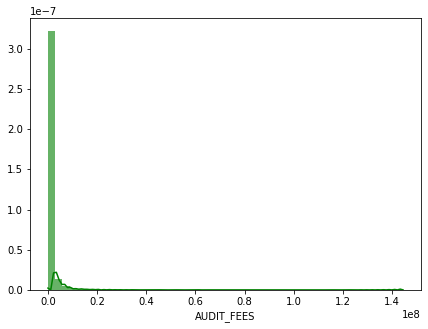

In [30]:
print(mergedData["AUDIT_FEES"].describe())
plt.figure(figsize=(7,5))
sns.distplot(mergedData["AUDIT_FEES"], color='g', bins=50, hist_kws={'alpha':0.6})
plt.show()

From the graph above, we see that it is rightly skewed. So we would like to analyze individual distributions to understand the attributes and the ranges of each attributes. Also, we would see if they share a similar distribution as the 'AUDIT_FEES' distribition. 

In [31]:
mergedData_num = mergedData.select_dtypes(include=["int64", "float64"])

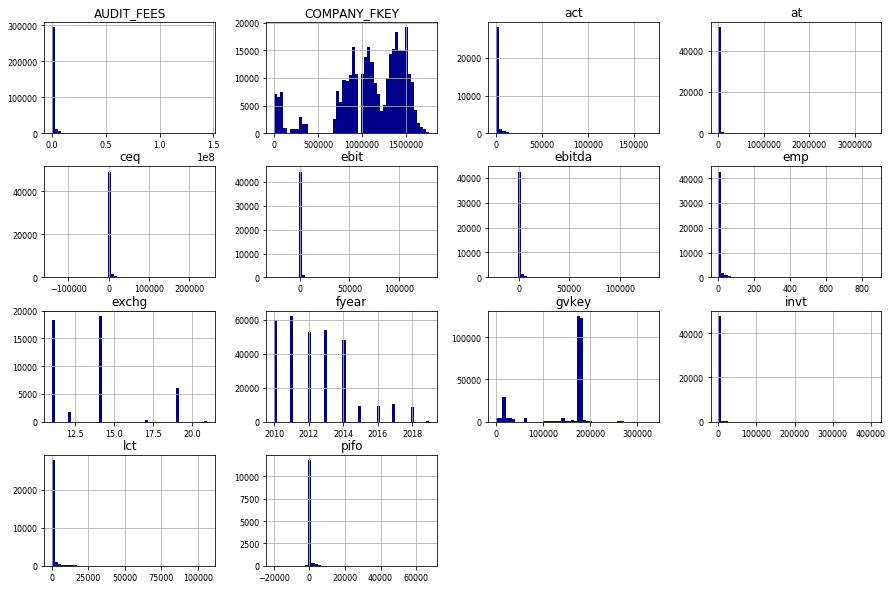

In [32]:
mergedData_num.hist(figsize=(15,10), color="darkblue", bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

Now, we learned that 'act', 'at', 'ceq', 'ebit', 'ebitda', 'emp', 'invt', 'lct', anf "pifo" in the graphs above, have a similar distirbution as "AUDIT_FEES" distribution. Next, we wee which firm characteristics has a strong correlated relationship with 'AUDIT_FEES".

In [33]:
mergedData_num_corr = mergedData_num.corr()["AUDIT_FEES"][1:]
print(mergedData_num_corr,'\n ')
golden_features_list = mergedData_num_corr[abs(mergedData_num_corr) > 0.5].sort_values(ascending=False)
print("There are {} strongly correlated values with AUDIT_FEES: \n{}".format(len(golden_features_list), golden_features_list))

fyear           0.092900
COMPANY_FKEY   -0.118856
gvkey          -0.140564
act             0.717434
at              0.669304
ceq             0.677756
ebit            0.588307
ebitda          0.631247
emp             0.582305
invt            0.356945
lct             0.695260
pifo            0.434083
exchg          -0.232970
Name: AUDIT_FEES, dtype: float64 
 
There are 7 strongly correlated values with AUDIT_FEES: 
act       0.717434
lct       0.695260
ceq       0.677756
at        0.669304
ebitda    0.631247
ebit      0.588307
emp       0.582305
Name: AUDIT_FEES, dtype: float64


We may conclude that there is seven strong correlation between AUDIT_FEES and the firm characteristics. Now, we use a heat map to see if there are correlations between the characteristics. 

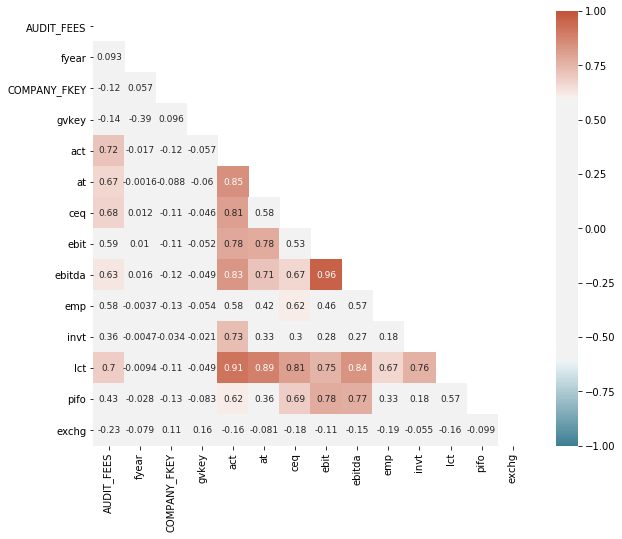

In [34]:
plt.figure(figsize=(10,8))
corr = mergedData_num.corr()
mask = np.zeros_like(corr)
matrix = np.triu(mergedData_num.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 20, sep=155, as_cmap=True)
sns.heatmap(corr,mask = matrix,annot = True, fmt='.2g', vmin=-1, vmax=1, 
            center= 0, cmap= cmap,square=True, annot_kws={'size': 9},robust = True); 
plt.show()

From the map, it shows that there are relationships between the characteristics. We had to determine which independent variables matter most and how they impact each other. Firstly, the 'ebit' and 'ebitda' realtionship indicates that earnings with/without taxes may not make a big difference. The correlation between 'ebit' and 'ebitda' is about 0.96, which is the highest in the map. The 'ceq' and 'act' relationship indicates that here is a strong relationship between current/ordinary equity total and asset current total. The correlation between'emp" and "act"/"invt" are also strong. The relationship between 'lct' and 'at' is also strong.  Plus, the feature, 'lct', has more stronger relationships with the other features.  Overall, I plan to drop "act", "ebit", "lct". Plus, the variable of "gvkey" may be dropped because it may not give any information to build the model as well. From the correlation, these relationships help to detemine with removing columns that means the same. 

In addition, the variables 'fyear' and 'datadate" have the similar meaning; "datadate" column would be dropped. I finally can clean and drop the null values on the merged data. I would able to perform OLS on the cleaned data.

In [35]:
cleanedData= mergedData.dropna().drop(columns=['act', 'ebit', "lct", "gvkey", "datadate"])

In [36]:
cleanedData.head(2)

,AUDIT_FEES,fyear,AUDITOR_NAME,COMPANY_FKEY,tic,indfmt,consol,popsrc,datafmt,conm,curcd,at,ceq,ebitda,emp,invt,pifo,exchg,costat,fic
0,18375000,2010,Deloitte & Touche LLP,1800,ABT,INDL,C,D,STD,ABBOTT LABORATORIES,USD,59462.266,22388.135,10663.086,90.0,3188.734,5988.0,11.0,A,USA
1,17472000,2011,Deloitte & Touche LLP,1800,ABT,INDL,C,D,STD,ABBOTT LABORATORIES,USD,60276.893,24439.833,12040.342,91.0,3284.249,4835.0,11.0,A,USA


In [37]:
cleanedData.describe()

,AUDIT_FEES,fyear,COMPANY_FKEY,at,ceq,ebitda,emp,invt,pifo,exchg
count,1.133000e+04,11330.000000,1.133000e+04,11330.000000,11330.000000,11330.000000,11330.000000,11330.000000,11330.000000,11330.000000
mean,3.151835e+06,2014.482524,9.597044e+05,6997.567973,2570.484580,905.318871,13.171431,433.607678,285.750122,12.905119
std,4.962281e+06,2.557815,4.904581e+05,23913.640601,10163.682961,3427.174140,38.105159,1742.068876,1872.759854,2.047391
min,0.000000e+00,2010.000000,1.800000e+03,0.000000,-11591.210000,-21913.000000,0.000000,0.000000,-19830.000000,11.000000
25%,6.068215e+05,2012.000000,8.099838e+05,190.045000,73.488750,3.851750,0.442000,0.000000,-0.254750,11.000000
50%,1.538895e+06,2015.000000,1.040161e+06,949.303000,365.429500,103.549000,2.305000,30.800500,5.431500,14.000000
75%,3.404990e+06,2017.000000,1.356006e+06,4101.100250,1390.135750,501.521000,9.000000,253.505250,83.066000,14.000000
max,6.570000e+07,2019.000000,1.768224e+06,531864.000000,191794.000000,70744.000000,647.500000,62567.000000,67504.000000,21.000000


Since we have characteristics variables, we would like to know which those variables may improve the accuracy of the model.

In [43]:
print(cleanedData["indfmt"].value_counts())
print(cleanedData["consol"].value_counts())
print(cleanedData["popsrc"].value_counts())
print(cleanedData["datafmt"].value_counts())

INDL    11330
Name: indfmt, dtype: int64
C    11330
Name: consol, dtype: int64
D    11330
Name: popsrc, dtype: int64
STD    11330
Name: datafmt, dtype: int64


In [46]:
print(cleanedData["curcd"].value_counts())
print(cleanedData["costat"].value_counts())
# print(cleanedData["fic"].value_counts())
# print(cleanedData["AUDITOR_NAME"].value_counts())
# print(cleanedData["tic"].value_counts())
# print(cleanedData["COMPANY_FKEY"].value_counts())
# print(cleanedData["conm"].value_counts())

USD    11217
CAD      113
Name: curcd, dtype: int64
A    11200
I      130
Name: costat, dtype: int64


The variables, 'indfmt', 'consol, 'popsrc', and 'datafmt' above show that they have only one type. Categorical predictors must have more than one distinct value. Also, they may not give any information, such as data format is in standard deviation. They wouldn't make sense to have it in the model.

Even though the 'COMPANY_FKEY, 'costat', 'fic', 'conm', 'AUDITOR_NAME", 'BEST_EDAR_TICKER", categorical variables have more than one type,  they are excluded in the model because it would makes other variables being insignificant in the model. If the p-value of each variable is greater than 0.05, we may conclude that those variables are not useful in the model. Without the categorical predictors, we will have 'at', 'ebitda', 'exchg', 'pifo', 'emp', 'ceq', 'invt' and 'fyear' as the independent variables. 

In [41]:
result = sm.ols(formula="AUDIT_FEES ~  at + ebitda + exchg + pifo + emp + fyear + ceq + invt", data=cleanedData).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDIT_FEES   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     3050.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:08:03   Log-Likelihood:            -1.8425e+05
No. Observations:               11330   AIC:                         3.685e+05
Df Residuals:                   11321   BIC:                         3.686e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -7.07e+07   2.07e+07     -3.408      0.001   -1.11e+08      -3e+07
at           134.0866      4.300     31.183      0.000     125.658     142.515
ebitda      -186.7152     26.182     -7.131      0.000    -238.036    -135.394
exchg      -3.606e+05   1.32e+04    -27.338      0.000   -3.86e+05   -3.35e+05
pifo         192.7891     25.899      7.444      0.000     142.023     243.556
emp         4.017e+04    850.975     47.202      0.000    3.85e+04    4.18e+04
fyear       3.828e+04   1.03e+04      3.716      0.000    1.81e+04    5.85e+04
ceq          -53.9773      6.980     -7.733      0.000     -67.660     -40.295
invt         421.0913     18.684     22.538      0.000     384.468     457.714
==============================================================================
Omnibus:                     5246.345   Durbin-Watson:                   0.520
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           274738.530
Skew:                           1.458   Prob(JB):                         0.00
Kurtosis:                      26.947   Cond. No.                     2.13e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the OLS, the Adj. R-squared indicates that 68.3% of audit fees can be explained by several independent variables, 'at', 'ebitda', 'exchg', 'pifo', 'emp', 'ceq', 'invt' and 'fyear'. The coefficient is when an unit change in the predictor variable that would result in a change in the audit fees.

If we increase the 'at' (Assets Total), 'pifo' (Pretax Foreign Exchange), 'emp'(Employees), 'fyear'(Fiscal Year),  or 'invt' (Inventories) by an unit, the audit fees would be increased by 134.0866, 192.7891, 4.017e+04, 3.828e+04, 421.0913	respectively.  We may conclude that the company with higher assets would pay audit fees more. if the compnay has more pretax foreign exchange, this company has to pay more. The company with more employees pay more. If they have more inventories, they pay audit fees more. The audit fees increase every next year. 

At last, the higher amount of 'ebitda'(Earning Before Interest), 'exchg' (Stock Exchange), 'ceq' (Common/Ordinary Equity total) company would pay audit fees more. If we increase 'ebita', "exchg', and 'ceq' by an unit, the audit fees would be decreased by 
-186.7152, 3.606e+05, -53.9773 respectively.

Furthermore, each p-value of the independent variable are less than 0.05 which means they are statistically significant in the model. Nearly 4% of the data is used in this model because the data sets were merged and the null values were dropped. I would not want to add more predictors because it may overfit the model. 

### Conclusion

EDA is a powerful statistical method that identifies which variables have impact on an interest and provides insights. We have to understand how and which independent variables matter most and how they impact each other. For example, I performed correlation analysis to understand the feature-feature relationships and improve the model. I eliminated some factors to get the best fit since I hypothesized several independent variables that may have the same meanings. On the other hand, some factors may help the prediction of audit fees. Explaining audit fees may be difficut because there may have other factors to consider about such as some variables may influence each other. Overall, I learned the importance of EDA, how to explore and understand the data  so we can build the better models. As a data science major, I work with machine learning. I would use EDA more often because if we create better models, we would improve machine learning. 
